# Systems of Nonlinear Equations

We have covered root finding algorithms for univariate scalar functions (Module 09), optimization algorithms for univariate scalar functions (Module 10), and optimization algoritms for multivariate scalar functions (Module 11). Now we will tacklesolving systems of equations. Broadly speaking, these are classified as sets of multivariate functions.  Our goal in "solving" them is to find the values of the complete set of variables that results in each of our equations being equal to zero.  It is high dimensional root finding. As an example, consider solving the followingsystem of nonlinear equations:

<div class = "alert alert-block alert-warning">
    <b>Important</b>: In this assignment we are covering best practices for solving systems of <b>nonlinear equations</b>.  You can apply these methods to a system of linear equations, but there are much more efficient, closed-form analytical solutions based on linear algebra. If you are dealing with linear systems, then you want to use linear methods since they are more efficient and stable than the iterative, numerical solutions we'll use here.
    </div>

\begin{align}
    x^2 - 3y &= 14.75z - w^4 \\
    25 &= x^3 - z \\ 
    0 &= \ln(z) - z^2 + 2x + 3 \\
    z + xw &= 74
\end{align}

It is clear that we cannot solve any one equation above to determine the values for w, x, y, and z that satisfy these equations. We have to solve all four of them together, as a system, to do that.  We do have analytical methods that are useful - most students default to a substitution method, for example.  In general, this is fine if you want an analytical solution but we should note two problems with the approach.  First, soliving large nonlinear systems this way requires extensive algebraic manipulations, which is both extremely tedious and extremely error-prone. Second, it isn't always possible to solve a system of nonlinear equations using analytical methods. More frequently, we will rely on numerical methods to solve nonlinear systems.  Similar to the cases we've already considered (e.g., a Newton-Raphson iteration), they are based on iterative solutions that proceed until the system reaches some convergence threshold. Just like with univariate equations, our convergence threshold is that we want the equations to evaluate to zero, it's just in this case, we want each and every equation to equal zero.

Now that we have a basic familiarity, we'll jump straight into the root finding algorithms available in Python. Solving nonlinear systems numerically is, in general, very difficult, and it requires both good algorithms and good initial guesses, so we'll skip writing our own routines like we did with univariate functions, but it is important to know that the basic approach of iteratively updating variable values until reaching your convergence threshold is the same.

When we solve a system of equations numerically in Python (or in most softwares), we need to write that system as a set of equations that should evaluate to zero once we find our solution. So no matter how the functions are presented to me, I will convert them into a form where the left-hand-side is zero, and the right hand side specifies the function. Following this logic, I would write the above system as:

\begin{align}
    0 &= -x^2 - + 3y + 14.75z - w^4 \\
    0 &= x^2 - z - 25 \\
    0 &= \ln(z) - z^2 + 2x + 3 \\
    0 &= z + xw - 74
\end{align}

That is the form we want to work with moving forward.

## An intuitive function definition to define this system

Just as in root finding and optimization for scalar equations, we want to construct a function that encodes this system and returns the left hand side of our equation(s). No problem, right?  We know how to create a multivariate function, so this is straightforward.  We will walk through the way we would probably do this intuitively, and then we'll explain what that won't work for a numerical solution.

```python
def F(w,x,y,z):
    eq1 =  -x**2 +3*y + 14.75*z - w**4
    eq2 =   x**2 - z - 25
    eq3 =   np.log(z) - z**2 + 2*x + 3
    eq4 =   z + x*w - 74
    return [eq1, eq2, eq3, eq4]   #Technically, this will return a list [eq1, eq2, eq3, eq4]
```

In [1]:
import numpy as np
import scipy.optimize as opt

In [2]:
def F(w,x,y,z):
    eq1 =  -x**2 +3*y + 14.75*z - w**4
    eq2 =   x**2 - z - 25
    eq3 =   np.log(z) - z**2 + 2*x + 3
    eq4 =   z + x*w - 74
    return [eq1, eq2, eq3, eq4]   #Technically, this will return a list [eq1, eq2, eq3, eq4]

Now, I can run that function for any (w,x,y,z) set and see the LHS value returned by each equation.  There is about a 0\% chance they are all equal to zero.

```python
F(1,2,3,4)
```

In [3]:
F(1,2,3,4)

[63.0, -25, -7.613705638880109, -68]

## Note the incompatibility with Scipy's `opt.root()`

Technically, there is nothing wrong with our function.  It evaluates the system.  It is just not compatible with Python syntax for numerical root finding, so this function form is not approprite for a multivariate root finding algorithm.  We have to do two things to make this work:

1. We have to recognize that our root finding algorithm is iterative. It is going to vary the values of w, x, y, and z until it converges. As in the case with optimization of multivariate functions, when we intend to vary these values iteratively, we *usually* need to pass them as the first argument to the function as a collection (a vector, array, list, tuple, etc.). That means we will pack w, x, y, and z into a single vector-like variable, just like we did when regressing $K_m$ and $V_{max}$ with the Michaelis-Menten model in Module 11.
2. Similar to the way our root finding algorithm wants all of our unknown variables input as an array-like quantity, it wants our function to return the left-hand-side solution to each equation in an array-like set of identical size to our set of variables.

### Defining a multivariate vector function for compatibility with `opt.root()`

Taking both of these things together, we are now working with a ***multivariate vector function***.  It is multivariate because it depends on 4 different independent variables, and it is a vector function because it returns a vector quantity instead of a scalar quantity.  It's easy to do, we just need to understand the two above points, which is what the root finding algorithm needs from us.  With that in mind, we'll construct our system as a multivariate vector function (with a vector argument). Python is actually pretty forgiving in terms of whether you provide inputs as lists, arrays, tuples, or a mix thereof, but in general, I prefer to use a consistent type and dimensionality for inputs and outputs:

```python
def F(var): #the name "var" is arbitrary; it is name of local variable that contains w, x, y, and z

    #We'll work with our "vector" argument var

    w, x, y, z = var   #I like to relabel elements of the vector variable for readability

    #Now we'll define our "vector" output; I'll work with a list

    LHS1 =  -x**2 + 3*y + 14.75*z - w**4
    LHS2 =   x**2 - z - 25
    LHS3 =   np.log(z) - z**2 + 2*x + 3
    LHS4 =   z + x*w - 74
    retval = [LHS1, LHS2, LHS3, LHS4] #I'm using a list, but you can return a tuple or array just as easily.
    return retval
```

In [4]:
def F(var):
    w, x, y, z = var   #I like to relabel elements of the vector variable for readability
    LHS1 =  -x**2 + 3*y + 14.75*z - w**4
    LHS2 =   x**2 - z - 25
    LHS3 =   np.log(z) - z**2 + 2*x + 3
    LHS4 =   z + x*w - 74
    retval = [LHS1, LHS2, LHS3, LHS4] #I'm using a list, but you can return a tuple or array just as easily.
    return retval

### Confirm that this function will accept an array input and return an array output

Now, if we want to run this function for the same input as last time, we need to provide a vector argument. I'll use a list.

    F([1,2,3,4]) #Using a 4-element list because it is consistent with my return structure.

In [5]:
F([1,2,3,4])

[63.0, -25, -7.613705638880109, -68]

### Solve system with `opt.root()`

Now that we've constructed the function, the syntax for the root finding algorithm is straightforward.  We'll use scipy.optimize.root. This is the multivariate analog of `scipy.optimize.root_scalar()`, which we used in Module 09. As usual, I have aliased `scipy.optimize` as `opt`, so my syntax is:

```python
var0 = [10, 10, 10, 10] #This is a list with my 4 initial guesses at the "roots" for w, x, y, and z
opt.root(F, var0)
```

At a minimum, I have to provide the function name (F) and my initial guess at the roots (w, x, y, and z) that give F = 0.

In [6]:
var0 = [10, 10, 10, 10] #This is a list with my 4 initial guesses at the "roots" for w, x, y, and z
opt.root(F, var0)

    fjac: array([[-9.99999786e-01,  2.16439481e-06,  4.12394877e-08,
         6.54018117e-04],
       [-4.89864222e-04, -6.54259823e-01, -1.19090081e-01,
        -7.46834250e-01],
       [ 4.33332846e-04, -7.34506405e-01, -1.35140183e-01,
         6.65009236e-01],
       [-2.68338866e-07,  1.80123360e-01, -9.83643575e-01,
        -9.44365147e-04]])
     fun: array([ 4.63944161e-07, -2.01083594e-11,  2.87059265e-12,  9.85522774e-11])
 message: 'The solution converged.'
    nfev: 293
     qtf: array([ 5.71880420e-05,  4.29964652e-08, -5.28577241e-08,  9.90538145e-10])
       r: array([ 8.27419961e+03,  1.09944077e+01, -2.87554327e+00, -1.47493661e+01,
       -1.67940052e+01, -1.39469538e-03,  7.99711662e-01,  1.23000526e-03,
        2.42664776e+00,  7.24858618e+00])
  status: 1
 success: True
       x: array([1.30451990e+01, 5.37463986e+00, 9.64394731e+03, 3.88675366e+00])

`opt.root()` is quite flexible as it includes several root finding algorithms (`hybrid`, `levenberg-marquardt`, `kyrlov`, etc.). Method selection is easy with `opt.root()`; similar to everything we've seen with `opt.minimize()`, you can select the algorithm using the method keyword.  So if I wanted to change from the default `hybr` method to `Levenberg-Marquardt`, I would do so by adding the method keyword argument and passing the string `LM`, which specifies Levenberg-Marquardt.

```python
opt.root(F, var0, method = 'LM')
```

As with minimization routines, the algorithms are all highly configurable using various options and keyword arguments, but these n-dimensional root finding algorithms using have algorithm specific options rather than options that are universal to all algorithms.  You'll need to consult the specific algoritm to see what options are available for that particular method, but each uses the same basic syntax of keyword arguments and/or options dictionaries, both of which are covered in Modules 09 - 11.

## A Word of Caution

Solving algebraic systems of nonlinear equations using numerical methods is incredibly difficult; you need a good algorithm and good-to-very good initial guesses.  Unfortunately, it can be difficult to provide good initial guesses. We should use our physical insights about the systems we are studying to make initial guesses that we think will be very close to the actual solution, otherwise, it is unlikely that our solvers will converge for difficult nonlinear systems.  In fact, the first example in this worksheet is only easily solved by the `hybr` and `LM` algorithms, whereas others won't converge easily.

## One final useful skill

Providing a Jacobian is usually a good idea when you are solving systems of equations numerically. It can be essential to performance and stability for difficult systems.  Most of the algorithms available in `opt.root()` will accept a Jacobian input.  Since it is such an essential skill, we'll demonstrate its usage.  The Jacobian is the set of partial derivatives of each function in your system with respect to each variable. In the system above, that means my Jacobian will be a 4x4 matrix since I'd have to take a partial derivative of each equation with respect to w, x, y, and z.  It isn't *hard*, but it is tedious (although you may want to look at symbolic, numerical, and/or automatica differentiation methods for generating Jacobians, which can make it much easier.  We won't cover that here). We'll go through a simpler example and create the corresponding Jacobian analytically.

Here's a simple system of equations written as functions of (a,b):

\begin{align}
    0 &= a^3 - e^{-b} \\
    0 &= ab - b^2 + 5
\end{align}

We can encode that a multivariate vector function in Python.  Here, I am choosing to return the left hand side of these equations in a numpy array:

```python
def q(v):
    a, b = v
    eq1 = a**3 - np.exp(-b)
    eq2 = a*b - b**2 + 5
    return np.array([eq1, eq2])
```

Now for the Jacobian, we need to calculate partial derivatives. a is my first variable, b is my second variable.  So I need to create a matrix that is:

$$J = \begin{vmatrix}
\frac{df_1}{da} & \frac{df_1}{db} \\
\frac{df_2}{da} & \frac{df_2}{db}
\end{vmatrix}$$

In other words, the first row contains the partial derivatives of the first function with respect to each variable, the second row contains the partial derivative of the second function with respect to each variable, and so forth.  For this system, that becomes:

$$J = \begin{vmatrix}
3a^2 & e^{-b}\\
b & a - 2b
\end{vmatrix}$$

This can be defined as a function in Python as follows (using np.arrays):

```python
def jacobian(v):
    a, b = v
    jac11 = 3*a**2
    jac12 = np.exp(-b)
    jac21 = b
    jac22 = a - 2*b
    jac   = np.array([[jac11, jac12], [jac21, jac22]])
    return jac
```

Note:  The reason I'm using np.arrays here is that they index like a matrix, and I'm most comfortable treating a Jacobian as a matrix.  But you could do this with a list or a tuple if you wanted to. 

Then we add the jacobian to the optimization routine using the `jac` keyword argument with following syntax:

```python
v0 = np.array([1,1])
opt.root(q, v0, method = 'hybr', jac = jacobian)
```

In [7]:
def q(v):
    a, b = v
    eq1 = a**3 - np.exp(-b)
    eq2 = a*b - b**2 + 5
    return np.array([eq1, eq2])

def jacobian(v):
    a, b = v
    jac11 = 3*a**2
    jac12 = np.exp(-b)
    jac21 = b
    jac22 = a - 2*b
    jac   = np.array([[jac11, jac12], [jac21, jac22]])
    return jac

v0 = np.array([1,1])
opt.root(q, v0, method = 'hybr', jac = jacobian)

    fjac: array([[-0.22118893, -0.97523098],
       [ 0.97523098, -0.22118893]])
     fun: array([-8.22536483e-14, -7.54063478e-13])
 message: 'The solution converged.'
    nfev: 14
    njev: 1
     qtf: array([-1.69990286e-09, -1.94595797e-10])
       r: array([-2.70315945,  4.04341967,  1.03995867])
  status: 1
 success: True
       x: array([0.43946782, 2.46657235])

## Least Squares Revisited: `opt.least_squares()`

Now that we have started working with multivariate vector functions, there is one final tool I want to cover from `Scipy.optimize` - least_squares.

This routine accomplishes the same things that we did in Supplement 11 for the Michaelis-Menten example; however, it is specifically designed for nonlinear least squares and offers some nice options like robust fitting, whereas `opt.minimize()` just minimizes the function that we supply to it.  In general, writing alternative "least squares" algorithms and properly scaling data requires a good understanding of the methods and the data, and the `opt.least_squares()` algorithm is built to handle some of this for us. The major difference between `opt.minimize()` and `opt.least_squares()` (other than the latter being specifically designed for least squares problem) is that `opt.minimize()` works on a scalar function (i.e., a function that returns the sum of squares), while `opt.least_squares()` works on a vector function.  Specifically, we provide `opt.least_squares()` with a function that calculates the vector of residuals, the difference between measurement and model, that includes every data point, and then `opt.least_squares()` generates the objective function automatically from that full vector of residuals. Revisiting that Michaelis-Menten example, let's load the data again:

In [8]:
CS = np.array([0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]) #mmol/L
rate = np.array([0, 0.017537467, 0.030941975, 0.080327165, 0.1643835, 0.26569368, 0.745442547, 1.295792328, 2.419014706, 4.0402125, 5.534947297, 5.127217742, 7.074911496]) #mmol/L/min

### Write a multivariate vector function that returns an array of residuals

Now we'll set up the least squares problem by creating a function that returns a *vector* of residuals for each data point; we still need it to take variable parameters ($V_{max}$ and $K_m$) as a vector input, and we have to pass that input as the first argument to the function.  We also need to pass our experimental concentrations and rates in order to calculate model predictions and residuals:

```python
def resid(par, Cexp, rexp):
    Vmax, Km = par
    rmod     = (Vmax*Cexp)/(Km + Cexp)
    residual = (rexp - rmod)
    return     residual
par0 = [7, 0.4]
resid(np.array([7,0.4]), CS, rate)    
```
The bottom line in that section of code is just running the function for an initial guess of $V_{max} = 7$ and $K_m = 0.4$.

In [9]:
def resid(par, Cexp, rexp):
    Vmax, Km = par
    rmod     = (Vmax*Cexp)/(Km + Cexp)
    residual = (rexp - rmod)
    return     residual
par0 = [7, 0.4]
resid(np.array([7,0.4]), CS, rate) 

array([ 0.00000000e+00,  8.11078978e-05, -3.88389565e-03, -6.09258809e-03,
       -6.34820732e-03, -6.76396533e-02, -3.23352308e-02, -1.04207672e-01,
        8.56813727e-02,  1.51323611e-01,  5.34947297e-01, -7.06115591e-01,
        5.93430015e-01])

### Find best fit parameters using `opt.least_squares()`

Now that we have a function that returns residuals when we provide 1) the parameter set, 2) experimental concentrations, and 3) experimental rates, we are ready to use opt.least_squares to find optimal values for $V_{max}$ and $K_m$.  I'm using the args keyword to pass CS and rate to the function, and I'm adding the verbose keyword to ask for a detailed output of iteration progress.

    par0 = np.array([7, 0.4])
    opt.least_squares(resid, par0, args = (CS, rate), verbose = 2)

In [10]:
par0 = np.array([7, 0.4])
opt.least_squares(resid, par0, args = (CS, rate), verbose = 2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9187e-01                                    1.49e+00    
       1              2         5.5471e-01      3.72e-02       2.06e-01       9.68e-03    
       2              3         5.5471e-01      8.21e-07       5.00e-04       9.26e-06    
       3              4         5.5471e-01      1.91e-12       1.68e-06       8.12e-08    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 5.9187e-01, final cost 5.5471e-01, first-order optimality 8.12e-08.


 active_mask: array([0., 0.])
        cost: 0.5547124699052083
         fun: array([ 0.00000000e+00, -2.85817665e-05, -4.10469633e-03, -6.65500328e-03,
       -7.50616083e-03, -7.00769297e-02, -3.91501641e-02, -1.19326840e-01,
        5.33159251e-02,  7.73111889e-02,  4.21195403e-01, -8.55199246e-01,
        4.13562724e-01])
        grad: array([-3.07683062e-09,  8.12494461e-08])
         jac: array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.43749831e-03,  4.28172126e-02],
       [-4.86314275e-03,  8.52184794e-02],
       [-1.20698110e-02,  2.09971659e-01],
       [-2.38517360e-02,  4.09986667e-01],
       [-4.65921676e-02,  7.82214008e-01],
       [-1.08871577e-01,  1.70839684e+00],
       [-1.96364628e-01,  2.77879338e+00],
       [-3.28268859e-01,  3.88292611e+00],
       [-5.49899715e-01,  4.35839659e+00],
       [-7.09593931e-01,  3.62868726e+00],
       [-8.30131551e-01,  2.48309654e+00],
       [-9.24341422e-01,  1.23147213e+00]])
     message: '`ftol` termination condition

### Adding bounds to `opt.least_squares()` parameters

You can add bounds to this routine when using either trf or dogbox algorithms:

    opt.least_squares(resid, par0, method = 'trf', args = (CS, rate), verbose = 2, bounds = [(6.8, 0.1), (7.5, 0.6)])
    
Note that the structure of the bounds here is different from `opt.minimize()`; it is like the convention used for `opt.curve_fit()`. Here, the bounds argument is always formatted as $[(\textrm{lower bounds}), (\textrm{upper bounds})]$, where lower bounds and upper bounds are tuples that contain the lower bound on each parameter (in the same sequence as the parameters are packed into par), and upper bound contains the corresponding upper bounds.

In [11]:
opt.least_squares(resid, par0, method = 'trf', args = (CS, rate), verbose = 2, bounds = [(6.8, 0.1), (7.5, 0.6)])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9187e-01                                    4.46e-01    
       1              2         5.5906e-01      3.28e-02       1.11e-01       3.65e-02    
       2              3         5.5490e-01      4.16e-03       7.66e-02       5.73e-03    
       3              4         5.5471e-01      1.86e-04       1.90e-02       3.22e-04    
       4              5         5.5471e-01      7.58e-07       1.28e-03       5.86e-06    
       5              6         5.5471e-01      5.46e-11       1.02e-05       5.73e-08    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 5.9187e-01, final cost 5.5471e-01, first-order optimality 5.73e-08.


 active_mask: array([0, 0])
        cost: 0.55471246990521
         fun: array([ 0.00000000e+00, -2.85823108e-05, -4.10469741e-03, -6.65500594e-03,
       -7.50616601e-03, -7.00769395e-02, -3.91501850e-02, -1.19326873e-01,
        5.33158832e-02,  7.73111544e-02,  4.21195392e-01, -8.55199230e-01,
        4.13562768e-01])
        grad: array([-3.41376827e-09, -3.00587740e-07])
         jac: array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.43749840e-03,  4.28172159e-02],
       [-4.86314292e-03,  8.52184854e-02],
       [-1.20698116e-02,  2.09971674e-01],
       [-2.38517370e-02,  4.09986697e-01],
       [-4.65921700e-02,  7.82214060e-01],
       [-1.08871580e-01,  1.70839695e+00],
       [-1.96364633e-01,  2.77879353e+00],
       [-3.28268870e-01,  3.88292629e+00],
       [-5.49899728e-01,  4.35839668e+00],
       [-7.09593937e-01,  3.62868738e+00],
       [-8.30131558e-01,  2.48309654e+00],
       [-9.24341421e-01,  1.23147207e+00]])
     message: '`ftol` termination condition is 

### Why would I use `opt.least_squares()` instead of `opt.minimize()`?

One thing I can point to is that this algorithm will return the Jacobian/Hessian approximations, which you can use to estimate confidence intervals on your parameters (not covered here).  Another nice features of `opt.least_squares()` is that it provides you with a few options for generating the loss function for more robust curve fitting. The default option is 'linear', which generates a standard SSE as the cost function. There are also `soft_l1`, `huber`, `cauchy`, and `arctan`, which may do a better job of handling outliers in the data set.  As an illustration, here is the optimal fit generated using default options; we will plot it against the experimental data; we'll also print out the parameter values and the loss function value at the optimum.

```python
import matplotlib.pyplot as plt
sol = opt.least_squares(resid, par0, args = (CS, rate))
print('Vmax and Km are', sol.x)
print('The minimum of the objective function is', sol.cost)
modfun = lambda Vmax, Km, Cexp: (Vmax*Cexp)/(Km + Cexp)
Cmodel = np.linspace(0, 5, 100)
plt.plot(Cmodel, modfun(sol.x[0], sol.x[1], Cmodel), color = 'black', linewidth = 1)
plt.scatter(CS, rate)
```

Vmax and Km are [7.20658909 0.40925669]
The minimum of the objective function is 0.5547124699052083


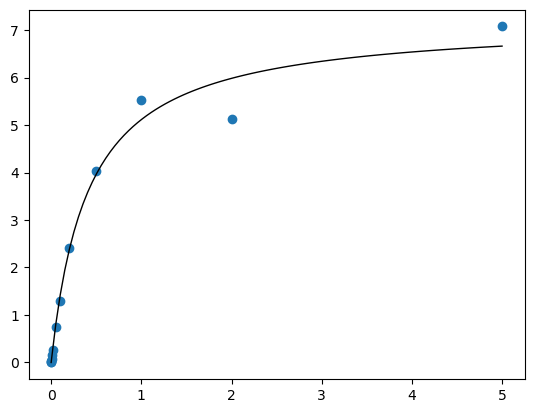

In [12]:
import matplotlib.pyplot as plt
sol = opt.least_squares(resid, par0, args = (CS, rate))
print('Vmax and Km are', sol.x)
print('The minimum of the objective function is', sol.cost)
modfun = lambda Vmax, Km, Cexp: (Vmax*Cexp)/(Km + Cexp)
Cmodel = np.linspace(0, 5, 100)
plt.plot(Cmodel, modfun(sol.x[0], sol.x[1], Cmodel), color = 'black', linewidth = 1)
plt.scatter(CS, rate)

Now let's contrast that with soft_l1 and cauchy loss functions.

```python
import matplotlib.pyplot as plt
default = opt.least_squares(resid, par0, args = (CS, rate))
soft    = opt.least_squares(resid, par0, args = (CS, rate), loss = 'soft_l1')
cauchy  = opt.least_squares(resid, par0, args = (CS, rate), loss = 'cauchy')
print('Vmax and Km using standard sum of squares are', default.x)
print('Vmax and Km using soft_l1 are', soft.x)
print('Vmax and Km using cauchy are', cauchy.x)
print('The minimum of the objective function using standard sum of squares is', default.cost)
print('The minimum of the objective function using soft_l1 is', soft.cost)
print('The minimum of the objective function using cauchy is', cauchy.cost)
modfun = lambda Vmax, Km, Cexp: (Vmax*Cexp)/(Km + Cexp)
Cmodel = np.linspace(0, 5, 100)
plt.plot(Cmodel, modfun(default.x[0], default.x[1], Cmodel), color = 'black', linewidth = 1)
plt.plot(Cmodel, modfun(soft.x[0], soft.x[1], Cmodel), color = 'blue', linewidth = 1)
plt.plot(Cmodel, modfun(cauchy.x[0], cauchy.x[1], Cmodel), color = 'green', linewidth = 1)
plt.scatter(CS, rate)
```

Vmax and Km using standard sum of squares are [7.20658909 0.40925669]
Vmax and Km using soft_l1 are [7.30480124 0.41696168]
Vmax and Km using cauchy are [7.43013646 0.42680022]
The minimum of the objective function using standard sum of squares is 0.5547124699052083
The minimum of the objective function using soft_l1 is 0.4933646113402903
The minimum of the objective function using cauchy is 0.4321935995722679


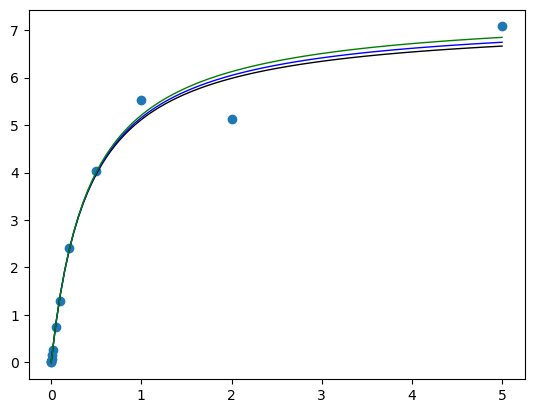

In [13]:
import matplotlib.pyplot as plt
default = opt.least_squares(resid, par0, args = (CS, rate))
soft    = opt.least_squares(resid, par0, args = (CS, rate), loss = 'soft_l1')
cauchy  = opt.least_squares(resid, par0, args = (CS, rate), loss = 'cauchy')
print('Vmax and Km using standard sum of squares are', default.x)
print('Vmax and Km using soft_l1 are', soft.x)
print('Vmax and Km using cauchy are', cauchy.x)
print('The minimum of the objective function using standard sum of squares is', default.cost)
print('The minimum of the objective function using soft_l1 is', soft.cost)
print('The minimum of the objective function using cauchy is', cauchy.cost)
modfun = lambda Vmax, Km, Cexp: (Vmax*Cexp)/(Km + Cexp)
Cmodel = np.linspace(0, 5, 100)
plt.plot(Cmodel, modfun(default.x[0], default.x[1], Cmodel), color = 'black', linewidth = 1)
plt.plot(Cmodel, modfun(soft.x[0], soft.x[1], Cmodel), color = 'blue', linewidth = 1)
plt.plot(Cmodel, modfun(cauchy.x[0], cauchy.x[1], Cmodel), color = 'green', linewidth = 1)
plt.scatter(CS, rate)

You should see a small difference in the parameter values and model fits and notice that the `soft_l1` and `cauchy` cost functions minimize the influence of what appears to be an outlier at about 2.0 mmol/L. I would not take a decrease in the cost function from `linear` to `soft_l1` to `cauchy` to be evidence of a better fit.  They formulate different cost functions, and so there is no good way to directly compare between them.  You would need to look at an $R^2$ for the model, confidence intervals on parameter estimates, and consider whether outlier rejection is appropriate or not based on statistical analysis - all of which is far beyond the scope of this Module.

<div class = "alert alert-block alert-info">
    <b>Added Bonus</b>: <code>opt.least_squares()</code> even lets you generate your own cost function by providing a function with the loss keyword argument, but that is a fairly advanced topic.
    </div>

Alternative loss functions use the f_scale parameter to determine the margin it uses to define what is an outlier, and it is usually of critical importance.  It's default value is 1 (set above). Try some different values for f_scale in the cell below. You can clearly see the difference it makes when we set f_scale to 2, 1, 0.5, and 0.1 for the soft_l1 loss function.  Again, this is an advanced topic. I would caution against too much manipulation without some pretty good background in statistics. I'm presenting it here just to give you a sense of the flexibility of the opt.least_squares package for advanced nonlinear regression.